In [98]:
import os
import json
import time

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

### KnowledgeGraph framework

In [83]:
from abc import ABC, abstractmethod

class KnowledgeGraph(ABC):
    def __init__(self, name=None, verbose = 0):
        self._name = name
        self._verbose = verbose
        
        self._entities = [] # list(string)
        self._relations = [] # list(string)
        # np.array([(head_entity, relation, tail_entity)])
        self._triples = np.zeros(shape=(0,3))
        
        self._built = False
        
    ####### PUBLIC #######
    @property
    def name(self):
        return self._name
    
    @property
    def entities(self):
        return self._entities
    
    @property
    def relations(self):
        return self._relations
    
    @property
    def triples(self):
        return self._triples
    
    def sample(self, k=1, negative=False):
        if negative:
            return self._sample_negative_loose(k)
        else:
            return self._sample_positive(k)
        
    def sample_english(self, k=1, negative=False):
        samples = self.sample(k, negative)
        
        english_samples = []
        for sample in samples:
            head_idx, relation_idx, tail_idx = sample
            head_id, relation_id, tail_id = self._entities[head_idx], self._relations[relation_idx], self._entities[tail_idx]
            head, relation, tail = self._id2entity(head_id), self._id2relation(relation_id), self._id2entity(tail_id)
            english_samples.append(relation.replace("{HEAD}", head).replace("{TAIL}", tail))
            
        return english_samples
            
        
    ####### PRIVATE #######
    
    @abstractmethod
    def _id2entity(self, eid):
        """
        A function that maps an entity id (eid) stored in the
        self._entities structure to an english identifier
        and/or description.
        """
        
    @abstractmethod
    def _id2relation(self, rid):
        """
        A function that maps an relation id (rid) stored in
        the self._relations structure to an english identifier
        and/or description.
        """
    
    @abstractmethod
    def _build_graph(self):
        """
        A function that builds the graph by reading in the data in
        its current format and populating self._entities, self._relations,
        self._triples, and at the end should set self._built to True.
        """
        pass
    
    @property
    def _is_built(self):
        return self._built
    
    @property
    def _num_entities(self):
        return len(self._entities)
    
    @property
    def _num_relations(self):
        return len(self._relations)
    
    @property
    def _num_triples(self):
        return self._triples.shape[0]
    
    def _validate_graph(self):
        # Make sure properties are filled out
        assert self._built, "The graph is not built. Please build " \
        "or check that your build_graph method sets self._build " \
        "to True after completion"
        
        # Make sure shape of self._triples is [N, 3]
        assert self._triples.shape[1] == 3, "The _triples property" \
        "must have a shape of 3 in the second dimension. " \
        
        # Make sure all head, tail entities and relations are valid
        head_entities = self._triples[:,0]
        assert head_entities.max() <= len(self._entities), "There" \
        "exists an entity in the head entities of the _triples " \
        "property that exceeds the number of available entities." \
        
        tail_entities = self._triples[:,2]
        assert tail_entities.max() <= len(self._entities), "There " \
        "exists an entity in the tail entities of the _triples " \
        "property that exceeds the number of available entities." \
        
        relations = self._triples[:,1]
        assert relations.max() <= len(self._relations), "There " \
        "exists an relations in the _triples " \
        "property that exceeds the number of available relations." \
        
        for eid in self._entities:
            assert self._id2entity(eid), f"One of the entities ({eid}) " \
            "has no mapping."
            
        for rid in self._relations:
            assert self._id2relation(rid), f"One of the relations ({rid}) " \
            "has no mapping."
            
        assert self.sample(10).shape == (10, 3), "Sampling yields the " \
            "wrong shape"
        
        assert self.sample(10, negative=True).shape == (10, 3), "Sampling " \
            "yields the wrong shape"
        
        if self._verbose >= 1:
            print("Graph was successfully validated!")
        
    def _sample_positive(self, k):
        triple_indices = np.random.choice(self._num_triples, k)
        positive_samples = self._triples[triple_indices]
        
        return positive_samples
    
    def _sample_negative_loose(self, k):
        # TODO(frg100): Make a strict version that makes sure not to
        # add existing triples
        head_entities = np.expand_dims(np.random.choice(self._num_entities, k), 0)
        relations = np.expand_dims(np.random.choice(self._num_relations, k), 0)
        tail_entities = np.expand_dims(np.random.choice(self._num_entities, k), 0)
        
        negative_samples = np.concatenate([head_entities, relations, tail_entities], axis=0).T
        
        return negative_samples
    
    def _load_json_mapping(self, json_path):
        # Load the map
        with open(json_path) as json_file:
            return json.load(json_file)
    
    

In [84]:
class FB15k237(KnowledgeGraph):
    def __init__(self, base_path=None, splits=['train', 'test', 'valid'], verbose = 0):
        super().__init__(name='FB15k-237', verbose = verbose)
        
        self._base_path = base_path
        self._splits = splits
        
        self._entity_mapping = None
        
        start = time.time()
        self._build_graph(verbose)
        end = time.time()
        if verbose >= 1:
            print(f"Building the graph took {round(end-start)} seconds")    
        
            
    def _id2entity(self, eid):
        if self._entity_mapping is None:
            assert False, "Entity mapping must be populated"
            
        if eid not in self._entity_mapping:
            #print(f"Entity with id ({eid}) is not mapped...")
            return None
            
        return self._entity_mapping[eid]['label']
    
    def _id2relation(self, rid):
        if self._relation_mapping is None:
            assert False, "Relation mapping must be populated"
            
        if rid not in self._relation_mapping:
            #print(f"Relation with id ({rid}) is not mapped...")
            return None
            
        return self._relation_mapping[rid]

    def _build_graph(self, verbose):
        # Load the mappings
        id2entity_path = os.path.join(self._base_path, "entity2wikidata.json")
        self._entity_mapping = self._load_json_mapping(id2entity_path)
        id2relation_path = os.path.join(self._base_path, "relation_mapping.json")
        self._relation_mapping = self._load_json_mapping(id2relation_path)
        
        # Initialize data structures for bookkeeping
        entities = set()
        relations = set()
        triples = set()

        num_data_points = sum(sum(1 for line in open(os.path.join(self._base_path, f"{split}.txt"))) for split in self._splits)
        
        # Load data
        for split in self._splits:
            path = os.path.join(self._base_path, f"{split}.txt")
            if verbose >= 1:
                print(f"Loading file {split}.txt")
                
            # Process into entities, relations, and triples
            with open(path, 'r') as f:
                for line in f:
                    # Check progress
                    last_percent_done = round((100*(self._num_triples-1))/num_data_points)
                    percent_done = round((100*self._num_triples)/num_data_points)
                    if verbose >= 2 and percent_done % 5 == 0 and last_percent_done % 5 != 0:
                        print(f"Data loading progress: [{percent_done}%]")
                    
                    # Initialize data
                    head, relation, tail = line.split()
                    head_id, relation_id, tail_id = None, None, None
                    
                    # If either of the entities has no natural language translation,
                    if not self._id2entity(head) or not self._id2entity(tail):
                        # Don't process it
                        continue
                    
                    if verbose >= 3 and percent_done % 5 == 0 and last_percent_done % 5 != 0:
                        print(f"{self._id2entity(head)} {relation} {self._id2entity(tail)}")
                    
                    # Process head
                    if head not in entities:
                        entities.add(head)
                        head_id = len(self._entities)
                        self._entities.append(head)
                    else:
                        head_id = self._entities.index(head)
                     
                    # Process tail
                    if tail not in entities:
                        entities.add(tail)
                        tail_id = len(self._entities)
                        self._entities.append(tail)
                    else:
                        tail_id = self._entities.index(tail)
                        
                    # Process relation
                    if relation not in relations:
                        relations.add(relation)
                        relation_id = len(self._relations)
                        self._relations.append(relation)
                    else:
                        relation_id = self._relations.index(relation)

                    # Create and add triple
                    triple = np.array([[head_id, relation_id, tail_id]], dtype=np.int32)  
                    if self._num_triples == 0:
                        self._triples = triple
                    else:
                        self._triples = np.append(self._triples, triple, axis=0)
                        
        # Build and validate
        self._built = True
        self._validate_graph()

### Modeling Framework

In [85]:
import transformers
from happytransformer import HappyTextToText, TTSettings

class LargeLanguageModel(ABC):
    def __init__(self, name=None, verbose = 0):
        self._name = name
        self._verbose = verbose
        
        self._grammar_model = HappyTextToText("T5", "vennify/t5-base-grammar-correction")
        self._grammar_model_args = TTSettings(num_beams=5, min_length=1)
        
        self._built = False
        
    ####### PUBLIC #######
    @property
    def name(self):
        return self._name
    
    def correct_grammar(self, sentence):
        return self._grammar_model.generate_text(f"grammar: {sentence}", args=self._grammar_model_args).text
    
    ####### PRIVATE #######
    
    @abstractmethod
    def batch_perplexity(self, eid):
        """
        A function that calculates a batch perplexity for a set of
        samples.
        """
        
    @property
    def _is_built(self):
        return self._built

In [99]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

class GPT2(LargeLanguageModel):
    def __init__(self, model_id="gpt2", verbose = 0):
        super().__init__(name='GPT2', verbose = verbose)
        
        self._model_id = model_id
        self._model = GPT2LMHeadModel.from_pretrained(self._model_id)
        self._tokenizer = GPT2TokenizerFast.from_pretrained(self._model_id)
        
        self._verbose = verbose
        
        self._built = True
        
    def batch_perplexity(self, samples):
        if self._verbose >= 1:
            print(f"[{self._model_id}] Calculating perplexity for {len(samples)} samples")
        perplexities = []
        for sample in tqdm(samples):
            sample = self.correct_grammar(sample)
            encoding = self._tokenizer(sample, return_tensors="pt")
            num_tokens = encoding.input_ids.shape[1]

            nlls = []
            for end_loc in range(1, num_tokens):
                input_ids = encoding.input_ids[:, 0:end_loc]
                target_ids = input_ids.clone()

                with torch.no_grad():
                    outputs = self._model(input_ids, labels=target_ids)
                    neg_log_likelihood = outputs[0] * end_loc

            nlls.append(neg_log_likelihood)

            perplexity = torch.exp(torch.stack(nlls).sum() / num_tokens)
            if self._verbose >= 2:
                print(f"[{self._model_id}] Sample <{sample}> has perplexity [{perplexity}]")
            perplexities.append(perplexity)

        if self._verbose >= 1:
            print(f"[{self._model_id}] Final average perplexity: {sum(perplexities)/len(perplexities)}")

        return perplexities 

In [106]:
from transformers import BertForMaskedLM, BertTokenizer
from torch.nn import functional as F


class BERT(LargeLanguageModel):
    def __init__(self, name='BERT', verbose = 0):
        super().__init__(name=name, verbose = verbose)
        
        self._name = name
        
        self._model_id = 'bert-base-cased'
        self._tokenizer = BertTokenizer.from_pretrained(self._model_id)
        self._model = BertForMaskedLM.from_pretrained(self._model_id)
        
        self._verbose = verbose
        
        self._built = True
        
    def batch_perplexity(self, samples):
        if self._verbose >= 1:
            print(f"[{self._name}] Calculating perplexity for {len(samples)} samples")
        perplexities = []
        for sample in tqdm(samples):
            sample_english = sample
            sample = self.correct_grammar(sample)
            
            encoding = self._tokenizer(sample, return_tensors="pt")
            #encoding = self._tokenizer.encode_plus(
            #    sample,
            #    add_special_tokens=True,
            #    truncation = True,
            #    padding = "max_length",
            #    return_attention_mask = True,
            #    return_tensors = "pt"
            #)
            num_tokens = encoding.input_ids.shape[1]
            
            input_ids = encoding.input_ids
            target_ids = input_ids.clone()
            
            #print(input_ids, input_ids.shape)
            
            nlls = []
            for mask_idx in range(input_ids[0].shape[0]):
                masked_input_ids = input_ids.clone()
                masked_input_ids[0][mask_idx] = self._tokenizer.mask_token_id
                
                with torch.no_grad():
                    outputs = self._model(input_ids).logits[:,mask_idx,:]
                    softmax = F.softmax(outputs, -1)
                    
                    target_id = target_ids[0][mask_idx]
                    nlls.append(softmax[0,target_id])

            perplexity = torch.exp((-1/num_tokens)*torch.log(torch.stack(nlls)).sum())
            if self._verbose >= 2:
                print(f"[{self._name}] Sample <{sample_english}> has perplexity [{perplexity}]")
            perplexities.append(perplexity)

        if self._verbose >= 1:
            print(f"[{self._name}] Final average perplexity: {sum(perplexities)/len(perplexities)}")

        return perplexities 

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_models(samples, model_a, perplexities_a, model_b, perplexities_b):
    f, ax = plt.subplots(figsize=(20,10))
    ax.set(yscale="log")

    model_one_ppx = np.array([ppx.item() for ppx in perplexities_a])
    model_two_ppx = np.array([ppx.item() for ppx in perplexities_b])

    sort_order = np.argsort(model_one_ppx).astype(int)

    sns.lineplot(x=samples, y=model_one_ppx[sort_order], label=model_a)
    sns.lineplot(x=samples, y=model_two_ppx[sort_order], label=model_b)

    plt.xticks(rotation=90)

    plt.legend()
    plt.ylabel('Perplexity')
    plt.title("Comparing perplexity on sample sentences between two models")

    plt.show()

In [95]:
def compare_triples(model, perplexities_pos, perplexities_neg):
    f, ax = plt.subplots(figsize=(20,10))
    ax.set(xscale="log")

    pos_ppx = np.array([ppx.item() for ppx in perplexities_pos])
    neg_ppx = np.array([ppx.item() for ppx in perplexities_neg])

    sns.distplot(pos_ppx, label="POSITIVE")
    sns.distplot(neg_ppx, label="NEGATIVE")

    plt.xticks(rotation=90)

    plt.legend()
    plt.ylabel('Perplexity Density')
    plt.title(f"Comparing perplexity on positive and negative sentences for {model}")

    plt.show()

### Execution

In [90]:
graph = FB15k237(base_path='./data/FB15k-237', splits=['train', 'valid','test'], verbose=2)

Loading file train.txt
Data loading progress: [5%]
Data loading progress: [10%]
Data loading progress: [15%]
Data loading progress: [20%]
Data loading progress: [25%]
Data loading progress: [30%]
Data loading progress: [35%]
Data loading progress: [40%]
Data loading progress: [45%]
Data loading progress: [50%]
Data loading progress: [55%]
Data loading progress: [60%]
Data loading progress: [65%]
Data loading progress: [70%]
Data loading progress: [75%]
Data loading progress: [80%]
Data loading progress: [85%]
Loading file valid.txt
Data loading progress: [90%]
Loading file test.txt
Data loading progress: [95%]
Graph was successfully validated!
Building the graph took 56 seconds


In [107]:
#model_gpt2 = GPT2(model_id="gpt2", verbose=2)
#model_gpt2_large = GPT2(model_id="gpt2-large", verbose=2)
model_bert = BERT(verbose=3)

05/27/2022 03:09:16 - INFO - happytransformer.happy_transformer -   Using model: cpu
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [108]:
#samples = graph.sample_english(25)
#gpt2_pos_perplexity = model_gpt2.batch_perplexity(samples)
#gpt2_large_pos_perplexity = model_gpt2_large.batch_perplexity(samples)
bert_pos_perplexity = model_bert.batch_perplexity(samples)

[BERT] Calculating perplexity for 25 samples


  4%|█▊                                          | 1/25 [00:04<01:45,  4.41s/it]

[BERT] Sample <John C. Reilly appears in the film Gangs of New York> has perplexity [20.703584671020508]


  8%|███▌                                        | 2/25 [00:07<01:29,  3.89s/it]

[BERT] Sample <Johnny Cash's music is rockabilly> has perplexity [50.52735900878906]


 12%|█████▎                                      | 3/25 [00:12<01:33,  4.24s/it]

[BERT] Sample <Robin Gibb is signed to the label Bertelsmann Music Group> has perplexity [16.059345245361328]


 16%|███████                                     | 4/25 [00:17<01:34,  4.50s/it]

[BERT] Sample <There is a forward on the roster of the Eintracht Braunschweig> has perplexity [11.09870719909668]


 20%|████████▊                                   | 5/25 [00:19<01:11,  3.56s/it]

[BERT] Sample <Maggie Smith lived in London> has perplexity [227.4838409423828]


 24%|██████████▌                                 | 6/25 [00:24<01:14,  3.93s/it]

[BERT] Sample <Austin Powers: The Spy Who Shagged Me is a parody> has perplexity [15.566831588745117]


 28%|████████████▎                               | 7/25 [00:27<01:09,  3.84s/it]

[BERT] Sample <The movie Juno hired a make-up artist> has perplexity [24.435379028320312]


 32%|██████████████                              | 8/25 [00:33<01:14,  4.38s/it]

[BERT] Sample <Brett Ratner is the director of the film "X-Men: The Last Stand"> has perplexity [9.852177619934082]


 36%|███████████████▊                            | 9/25 [00:36<01:06,  4.17s/it]

[BERT] Sample <Sioux City is located in the Central Time Zone> has perplexity [76.8041763305664]


 40%|█████████████████▏                         | 10/25 [00:42<01:08,  4.55s/it]

[BERT] Sample <Gustavo Cerati was nominated for the Latin Grammy Award for Album of the Year award> has perplexity [12.948718070983887]


 44%|██████████████████▉                        | 11/25 [00:46<01:00,  4.33s/it]

[BERT] Sample <The endowment of North Dakota State University is measured in United States dollar> has perplexity [15.400239944458008]


 48%|████████████████████▋                      | 12/25 [00:50<00:55,  4.24s/it]

[BERT] Sample <John Milius was born in United States of America> has perplexity [24.00444221496582]


 52%|██████████████████████▎                    | 13/25 [00:55<00:55,  4.62s/it]

[BERT] Sample <Alfie was nominated for the Academy Award for Best Supporting Actress award> has perplexity [22.052978515625]


 56%|████████████████████████                   | 14/25 [01:00<00:51,  4.66s/it]

[BERT] Sample <The 25th United States Congress has a member that represents the district of Indiana> has perplexity [13.877129554748535]


 60%|█████████████████████████▊                 | 15/25 [01:07<00:54,  5.42s/it]

[BERT] Sample <The actress that won the National Board of Review Award for Best Actor was in the movie The Descendants > has perplexity [5.856125831604004]


 64%|███████████████████████████▌               | 16/25 [01:11<00:44,  4.98s/it]

[BERT] Sample <Lower Normandy is located next to Upper Normandy> has perplexity [70.44271850585938]


 68%|█████████████████████████████▏             | 17/25 [01:16<00:39,  4.96s/it]

[BERT] Sample <6th United States Congress contains members that participated in the 7th United States Congress> has perplexity [13.129424095153809]


 72%|██████████████████████████████▉            | 18/25 [01:20<00:32,  4.66s/it]

[BERT] Sample <The domestic tuition of the Wesleyan University is measured in United States dollar> has perplexity [13.086652755737305]


 76%|████████████████████████████████▋          | 19/25 [01:25<00:28,  4.76s/it]

[BERT] Sample <Emile Kuri was the film set designer of It's a Wonderful Life> has perplexity [12.597039222717285]


 80%|██████████████████████████████████▍        | 20/25 [01:30<00:24,  4.96s/it]

[BERT] Sample <Megan McTavish was nominated for an award for Guiding Light> has perplexity [12.731600761413574]


 84%|████████████████████████████████████       | 21/25 [01:36<00:20,  5.02s/it]

[BERT] Sample <There is a defender on the roster of the Galatasaray S.K.> has perplexity [10.6641845703125]


 88%|█████████████████████████████████████▊     | 22/25 [01:39<00:13,  4.47s/it]

[BERT] Sample <The language of the film Naked Lunch is Arabic> has perplexity [21.421037673950195]


 92%|███████████████████████████████████████▌   | 23/25 [01:44<00:09,  4.58s/it]

[BERT] Sample <The Grammy Award for Best Small Ensemble Performance award is a kind of Grammy Award> has perplexity [13.793865203857422]


 96%|█████████████████████████████████████████▎ | 24/25 [01:50<00:05,  5.21s/it]

[BERT] Sample <The actress that won the Golden Globe Award for Best Foreign Language Film was in the movie The Sea Inside > has perplexity [6.59257173538208]


100%|███████████████████████████████████████████| 25/25 [01:58<00:00,  4.72s/it]

[BERT] Sample <John Gielgud has been nominated for an award along with Armin Mueller-Stahl> has perplexity [7.353515148162842]
[BERT] Final average perplexity: 29.13934898376465


In [ ]:
#negative_samples = graph.sample_english(25, negative=True)
#gpt2_neg_perplexity = model_gpt2.batch_perplexity(negative_samples)
#gpt2_large_neg_perplexity = model_gpt2_large.batch_perplexity(negative_samples)
bert_neg_perplexity = model_bert.batch_perplexity(negative_samples)

[BERT] Calculating perplexity for 25 samples


  4%|█▊                                          | 1/25 [00:05<02:07,  5.30s/it]

[BERT] Sample <David S. Goyer is a prequel of Grammy Award for Best Music Film> has perplexity [10.897078514099121]


  8%|███▌                                        | 2/25 [00:07<01:18,  3.43s/it]

[BERT] Sample <Algiers is a Suzhou> has perplexity [97.94026184082031]


 12%|█████▎                                      | 3/25 [00:11<01:18,  3.57s/it]

[BERT] Sample <The group Satyen Kappu usually has a Sheila E.> has perplexity [11.067286491394043]


 16%|███████                                     | 4/25 [00:13<01:05,  3.14s/it]

[BERT] Sample <The movie The Avengers was edited by Timeline> has perplexity [32.22820281982422]


 20%|████████▊                                   | 5/25 [00:18<01:16,  3.82s/it]

[BERT] Sample <The 'N Sync award is a kind of Mako Iwamatsu> has perplexity [8.464871406555176]


 24%|██████████▌                                 | 6/25 [00:21<01:07,  3.56s/it]

[BERT] Sample <Harry Andrews's instrument was the Chris Cornell> has perplexity [24.595664978027344]


 28%|████████████▎                               | 7/25 [00:25<01:05,  3.61s/it]

[BERT] Sample <The group Kamloops usually has a Hank Williams Jr.> has perplexity [12.801892280578613]


 32%|██████████████                              | 8/25 [00:31<01:15,  4.46s/it]

[BERT] Sample <The estimated number of mortgages in Nicholas II of Russia is provided by the Rang De Basanti> has perplexity [5.516938209533691]


 36%|███████████████▊                            | 9/25 [00:34<01:01,  3.86s/it]

[BERT] Sample <magnesium won an award at the organ> has perplexity [43.41610336303711]


 40%|█████████████████▏                         | 10/25 [00:37<00:55,  3.69s/it]

[BERT] Sample <Al Ain FC was born in Wim Wenders> has perplexity [28.291118621826172]


 44%|██████████████████▉                        | 11/25 [00:40<00:49,  3.54s/it]

[BERT] Sample <The film FC Sion was distributed by skin cancer> has perplexity [20.891345977783203]


In [104]:
import scipy

print(scipy.stats.ttest_ind(gpt2_pos_perplexity, gpt2_neg_perplexity))
print(scipy.stats.ttest_ind(gpt2_large_pos_perplexity, gpt2_large_neg_perplexity))
print(scipy.stats.ttest_ind(bert_pos_perplexity, bert_neg_perplexity))

Ttest_indResult(statistic=-4.286097727885394, pvalue=8.709093628921685e-05)
Ttest_indResult(statistic=-4.085985856923845, pvalue=0.000165894303784713)
Ttest_indResult(statistic=-1.0025262883358261, pvalue=0.3211167964671217)


In [ ]:
compare_models(samples, 'GPT2', gpt2_pos_perplexity, "GPT2-Large", gpt2_large_pos_perplexity)
compare_models(negative_samples, 'GPT2', gpt2_neg_perplexity, "GPT2-Large", gpt2_large_neg_perplexity)

compare_models(samples, 'GPT2', gpt2_pos_perplexity, "BERT", bert_pos_perplexity)
compare_models(negative_samples, 'GPT2', gpt2_neg_perplexity, "BERT", bert_neg_perplexity)

/Users/frg100/opt/anaconda3/envs/cs224u/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/frg100/opt/anaconda3/envs/cs224u/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


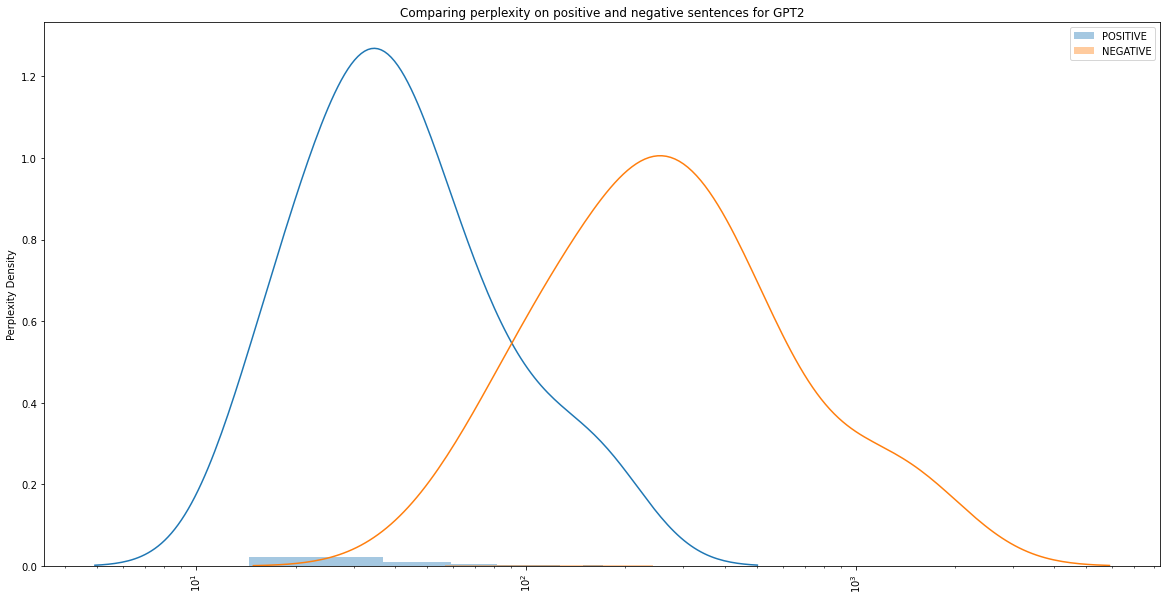

/Users/frg100/opt/anaconda3/envs/cs224u/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/frg100/opt/anaconda3/envs/cs224u/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


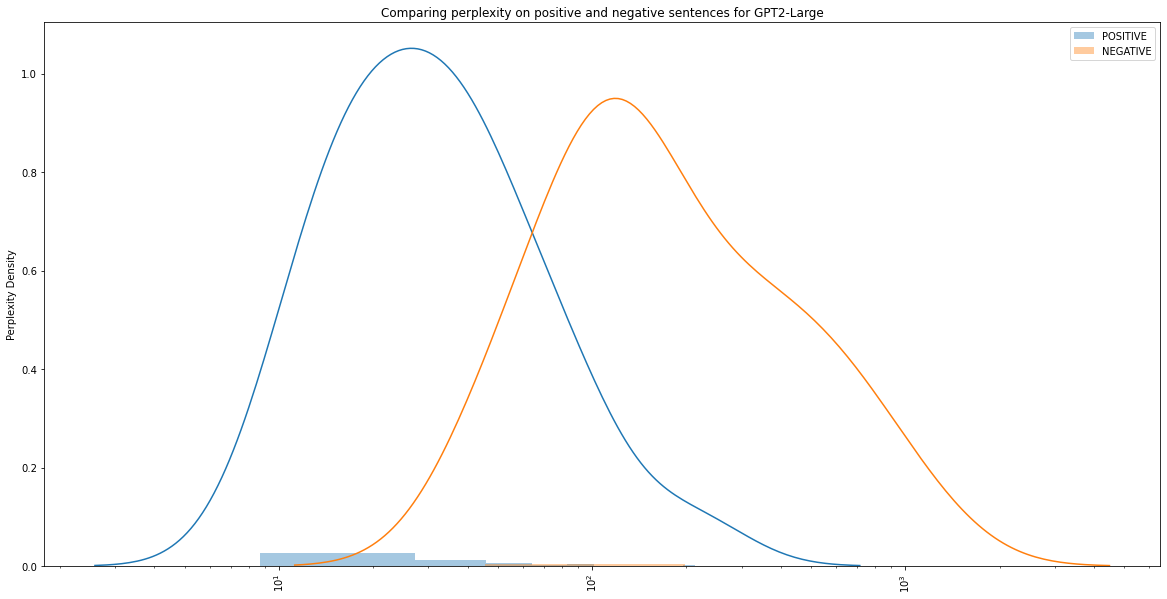

/Users/frg100/opt/anaconda3/envs/cs224u/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/frg100/opt/anaconda3/envs/cs224u/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


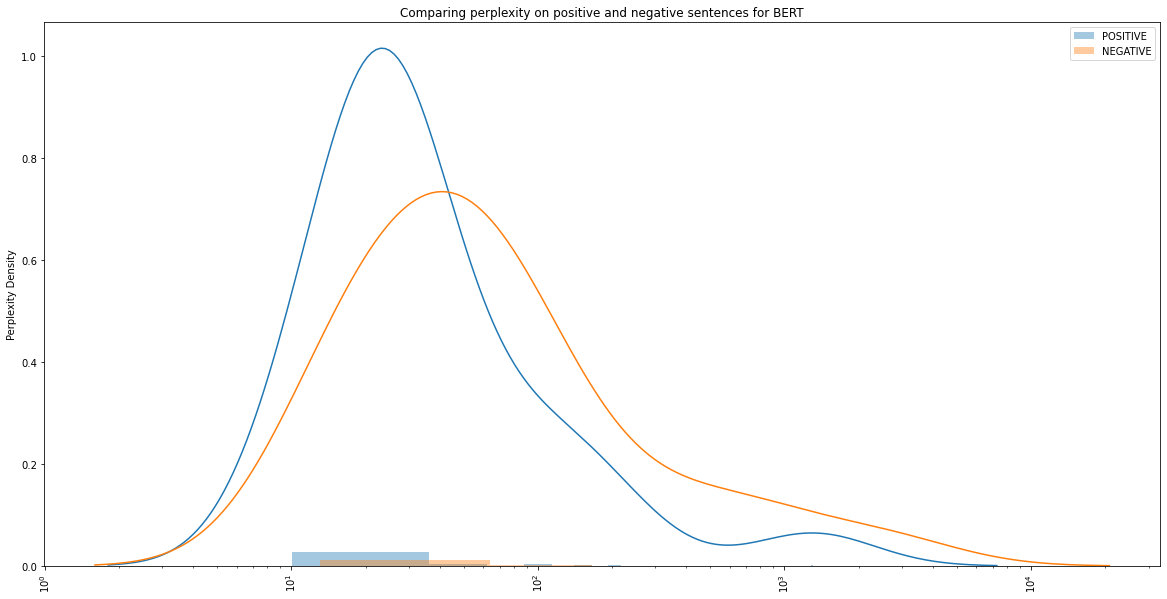

In [105]:
compare_triples('GPT2', gpt2_pos_perplexity, gpt2_neg_perplexity)
compare_triples('GPT2-Large', gpt2_large_pos_perplexity, gpt2_large_neg_perplexity)
compare_triples('BERT', bert_pos_perplexity, bert_neg_perplexity)

### Random Experiments

In [ ]:
weights_name = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(weights_name)
bert_model = BertModel.from_pretrained(weights_name)

In [ ]:
bert_tokenizer.batch_encode_plus(
    graph.sample_english(10),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest')

In [ ]:
def batch_perplexity(samples, verbose=0):
    print(f"Calculating perplexity for {len(samples)} samples")
    perplexities = []
    for sample in samples:
        encoding = tokenizer(sample, return_tensors="pt")
        num_tokens = encoding.input_ids.shape[1]

        nlls = []
        for end_loc in range(1, num_tokens):
            input_ids = encoding.input_ids[:, 0:end_loc]
            target_ids = input_ids.clone()

            with torch.no_grad():
                outputs = model(input_ids, labels=target_ids)
                neg_log_likelihood = outputs[0] * end_loc

        nlls.append(neg_log_likelihood)

        perplexity = torch.exp(torch.stack(nlls).sum() / end_loc)
        if verbose >= 2:
            print(f"Sample <{sample}> has perplexity [{perplexity}]")
        perplexities.append(perplexity)

    if verbose >= 1:
        print(f"Final average perplexity: {sum(perplexities)/len(perplexities)}")
        
    return perplexities

batch_perplexity(graph.sample_english(10, negative=False), verbose=2)

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

model_id = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_id)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

encodings = tokenizer("\n\n".join(graph.sample_english(10)), return_tensors="pt")

import torch
from tqdm import tqdm

max_length = model.config.n_positions
stride = 1

nlls = []
for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
    begin_loc = max(i + stride - max_length, 0)
    end_loc = min(i + stride, encodings.input_ids.size(1))
    trg_len = end_loc - i  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc]
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        print(begin_loc, end_loc)
        outputs = model(input_ids, labels=target_ids)
        neg_log_likelihood = outputs[0] * trg_len

    nlls.append(neg_log_likelihood)

ppl = torch.exp(torch.stack(nlls).sum() / end_loc)

In [ ]:
ppl

### Running the code

In [ ]:
graph = FB15k237(base_path='./data/FB15k-237', splits=['train', 'valid','test'], verbose=2)

In [ ]:
graph.sample_english(10, negative=False)

### Random Experiments

In [ ]:
# base_path='./data/FB15k-237'

# mapping = {}

# # Load file if it exists
# json_path = os.path.join(base_path, "relation_mapping.json")

# if os.path.exists(json_path):
#     json_file_read = open(json_path, 'r')
#     mapping = json.load(json_file_read)
#     json_file_read.close()


# # for rel in graph.relations:
# #     if rel not in mapping:
# #         relations_done = len(mapping.keys())
# #         relations_total = len(graph.relations)
# #         relations_left = relations_total - relations_done
# #         print(f"[{round(100*(relations_done/relations_total), 2)}%] done describing relations ({relations_left} left)")
        
# #         instance_idx = np.where(graph.triples[:, 1] == graph.relations.index(rel))[0][0]
# #         head, relation, tail = graph.triples[instance_idx]
# #         head, tail = graph._mid2entity(graph.entities[head]), graph._mid2entity(graph.entities[tail])
        
# #         format_string = input(f"{head} {rel} {tail}: ")
# #         mapping[rel] = format_string
# #         json_file_write = open(json_path, 'w')
# #         json.dump(mapping, json_file_write)
# #         json_file_write.close()
        
    

In [ ]:
# Generate the dataset using the functions


In [ ]:
# def see_relation_examples(relation, k = 1):
#     instance_indices = np.where(graph.triples[:, 1] == graph.relations.index(rel))[0][:k]
#     samples = graph.triples[instance_indices]
#     for sample in samples:
#         h, r, t = sample
#         print(graph._id2entity(graph.entities[h]), graph.relations[r], graph._id2entity(graph.entities[t]))
    
# see_relation_examples('/award/award_winner/awards_won./award/award_honor/award_winner', k=5)

In [ ]:
len(graph.relations)